In [22]:
import torch
from torch import nn
import torch.nn.functional as Fn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from tqdm import tqdm
from collections import Counter

from torchsummary import summary

In [2]:
np.random.seed(1292139)
torch.manual_seed(2894347)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
training_data = datasets.MNIST(
root="data",
train=True,
download=True,
transform=ToTensor()
)
test_data = datasets.MNIST(
root="data",
train=False,
download=True,
transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
train_classes = [label for _, label in training_data]
Counter(train_classes)

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

In [6]:
test_classes = [label for _, label in test_data]
Counter(test_classes)

Counter({7: 1028,
         2: 1032,
         1: 1135,
         0: 980,
         4: 982,
         9: 1009,
         5: 892,
         6: 958,
         3: 1010,
         8: 974})

train_test_split ensures that the split is done uniformly

In [7]:
validation_split = .2 #20% validation split
shuffle_dataset = True
random_seed= 42


train_idx, val_idx,_,_= train_test_split(range(len(training_data)),training_data.targets, test_size=0.2,train_size=0.8, shuffle=True, stratify=training_data.targets)
   
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

In [8]:
test_loader = DataLoader(test_data, batch_size=64,num_workers = 2)

In [9]:

train_loader = DataLoader(training_data, batch_size=64, 
                                           sampler=train_sampler,num_workers = 2)
val_loader = DataLoader(training_data, batch_size=64, sampler = valid_sampler, num_workers = 2)


x = training_data.data
y = training_data.targets.to(device)

x_train = x[train_idx].to(torch.float).to(device)
y_train = y[train_idx].to(device)

x_val = x[val_idx].to(torch.float).to(device)
y_val = y[val_idx].to(device)

x_test = test_data.data.to(torch.float).to(device)
y_test = test_data.targets.to(device)


In [10]:

lr = 1e-2
batch_size = 64
epochs = 15   


In [11]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3,padding=1)
    self.fc1   = nn.Linear(49*32, 500)
    self.fc2   = nn.Linear(500, 10)

    self.activ = nn.ReLU()
    self.softmax = nn.Softmax(dim=0)

  def pool(self, x, kernel_size=2):
    out = Fn.max_pool2d(x, kernel_size, stride=2)
    return out

  def forward(self, x):
    out = self.activ(self.conv1(x))
    out = self.pool(out)
    out = self.activ(self.conv2(out))
    out = self.pool(out)
    out = out.reshape(out.size(0), -1)
    out = self.activ(self.fc1(out))
    out = self.fc2(out)
    #out = self.softmax(out)
    return out

In [40]:
model = CNN().to(device)
#model.apply(init_wb)
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)

In [13]:

def acc(loader,model,cft = False):
  correct = 0
  total = 0
  pred = []
  actual = []
  with torch.no_grad():
      for images,labels in loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          if cft:
            for i in range(len(labels)):
              pred.append(predicted[i].to(torch.device('cpu')))
              actual.append(labels[i].to(torch.device('cpu')))
  if cft:
    return (100 * correct / total), confusion_matrix(actual,pred)
  else:
    return 100 * correct / total


def compute_loss(loader,model,Loss):
  loss = 0.0
  with torch.no_grad():
      for images,labels in loader:
          images = images.to(torch.float).to(device)
          labels = labels.to(device)
          outputs = model(images)
          loss += Loss(outputs,labels)
  return loss

In [14]:

def train(model,dataloader,Loss,optimiser,history = True):
    torch.cuda.empty_cache()
    run=0
    loss_list_train = []
    loss_list_val = []
    train_acc = []
    valid_acc = []
    run = 0 
    for epoch in range(epochs):
        for (batchidx, (features, targets)) in enumerate(dataloader):
          
            optimiser.zero_grad()
            pred = model(features.to(torch.float).to(device))
            epoch_loss = Loss(pred,targets.to(device))
      
            epoch_loss.backward()
            optimiser.step()
            run+=1
            if run % 200 == 0:
              print('Epoch {}/15: Epoch Loss: {:.2f}'.format(epoch+1, epoch_loss))
            

        with torch.no_grad():
          print('Epoch {} DONE'.format(epoch+1)) 
          if history:
            loss_list_train.append(compute_loss(dataloader,model,Loss))
            loss_list_val.append(compute_loss(val_loader,model,Loss))
            #train_acc.append(acc(dataloader,model))
            valid_acc.append(acc(val_loader,model))
            print(f'Train error :{loss_list_train[-1]}')
            print(f'Validation error :{loss_list_val[-1]}')         
            #print(f'Train accuracy :{train_acc[-1]}')
            print(f'Validation accuracy :{valid_acc[-1]}')
          print('\n')
    if history:
      return loss_list_train,loss_list_val,train_acc,valid_acc

In [41]:
losses = train(model,train_loader,loss_fn,optimiser)

Epoch 1/15: Epoch Loss: 0.19
Epoch 1/15: Epoch Loss: 0.26
Epoch 1/15: Epoch Loss: 0.15
Epoch 1 DONE
Train error :86.34843444824219
Validation error :20.794330596923828
Validation accuracy :96.73333333333333


Epoch 2/15: Epoch Loss: 0.16
Epoch 2/15: Epoch Loss: 0.07
Epoch 2/15: Epoch Loss: 0.15
Epoch 2/15: Epoch Loss: 0.11
Epoch 2 DONE
Train error :40.369163513183594
Validation error :11.479650497436523
Validation accuracy :98.2


Epoch 3/15: Epoch Loss: 0.01
Epoch 3/15: Epoch Loss: 0.01
Epoch 3/15: Epoch Loss: 0.09
Epoch 3/15: Epoch Loss: 0.04
Epoch 3 DONE
Train error :31.755409240722656
Validation error :10.679150581359863
Validation accuracy :98.28333333333333


Epoch 4/15: Epoch Loss: 0.02
Epoch 4/15: Epoch Loss: 0.09
Epoch 4/15: Epoch Loss: 0.02
Epoch 4/15: Epoch Loss: 0.08
Epoch 4 DONE
Train error :42.42111587524414
Validation error :12.63456916809082
Validation accuracy :97.98333333333333


Epoch 5/15: Epoch Loss: 0.05
Epoch 5/15: Epoch Loss: 0.01
Epoch 5/15: Epoch Loss: 0.00
Ep

In [42]:
test_acc = acc(test_loader,model,cft=False)
print(f'Accuracy on blind test data :{test_acc}')

Accuracy on blind test data :98.98


Text(0.5, 1.0, 'Train and validation error')

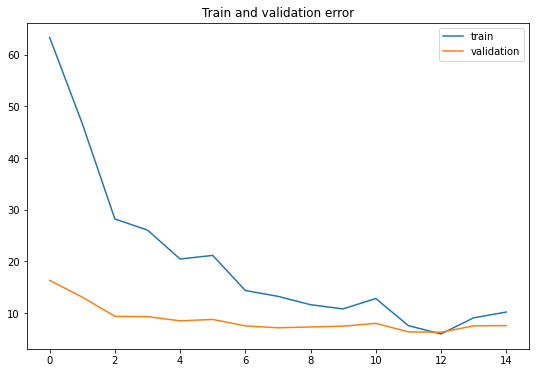

In [16]:
plt.figure(figsize=(9,6))
plt.plot(torch.tensor(losses[0]).detach().numpy(),label='train')
plt.plot(torch.tensor(losses[1]).detach().numpy(),label='validation')
plt.legend()
plt.title('Train and validation error')

Text(0.5, 1.0, 'prediction accuracy')

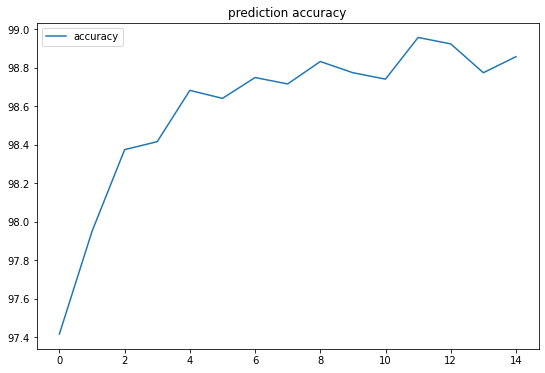

In [18]:
plt.figure(figsize=(9,6))
plt.plot(torch.tensor(losses[3]).detach().numpy(),label='accuracy')
plt.legend()
plt.title('prediction accuracy')

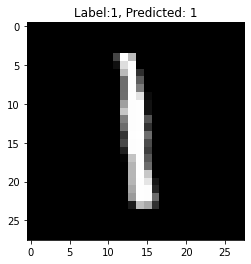

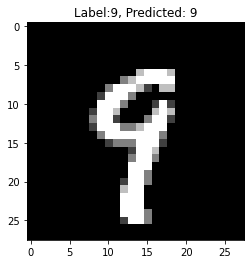

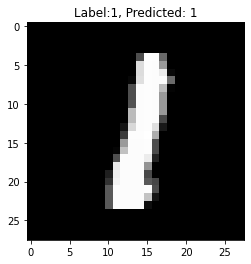

In [21]:
classes = ['0','1','2','3','4','5','6','7','8','9']
def predict_image(img,model):
  return torch.max(model(img.to(device)),1)[1]

np.random.seed(42)
random_idx = np.random.uniform(0,1,3)*10000
for i in random_idx:
  img, label = test_data[int(i)]
  plt.figure()
  plt.imshow(img[0],cmap='gray')
  plt.title(f'Label:{classes[label]}, Predicted: {classes[predict_image(img.reshape((1,1,28,28)), model)]}')
  plt.show()
  

In [24]:
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 14, 14]           9,248
              ReLU-4           [-1, 32, 14, 14]               0
            Linear-5                  [-1, 500]         784,500
              ReLU-6                  [-1, 500]               0
            Linear-7                   [-1, 10]           5,010
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 3.05
Estimated Total Size (MB): 3.54
----------------------------------------------------------------


The above summary chart indicates the input and output size at each layer.

It also has the total number of parameters which is equal to 799,078.
Of which 9568 are in conv layers while 789,510 are in fully connected layers.

Number of neurons in conv layers = 32*28*28+32*14*14 = 31360
Number of neurons in fully connected layers = 510
Total number of neurons = 31870. This is computed without considering input neurons or maxpool layers

In [36]:
class CNN_bn(nn.Module):
  def __init__(self):
    super(CNN_bn, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.fc1   = nn.Linear(49*32, 500)
    self.fc2   = nn.Linear(500, 10)

    self.activ = nn.ReLU()
    self.softmax = nn.Softmax(dim=0)

  def pool(self, x, kernel_size=2):
    out = Fn.max_pool2d(x, kernel_size, stride=2)
    return out

  def forward(self, x):
    out = self.activ(self.bn1(self.conv1(x)))
    out = self.pool(out)
    out = self.activ(self.bn2(self.conv2(out)))
    out = self.pool(out)
    out = out.reshape(out.size(0), -1)
    out = self.activ(self.fc1(out))
    out = self.fc2(out)
    #out = self.softmax(out)
    return out

In [37]:
model_bn = CNN_bn().to(device)
#model.apply(init_wb)
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model_bn.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)

In [38]:
losses = train(model_bn,train_loader,loss_fn,optimiser)

Epoch 1/15: Epoch Loss: 0.06
Epoch 1/15: Epoch Loss: 0.05
Epoch 1/15: Epoch Loss: 0.07
Epoch 1 DONE
Train error :32.745361328125
Validation error :9.529009819030762
Validation accuracy :98.4


Epoch 2/15: Epoch Loss: 0.14
Epoch 2/15: Epoch Loss: 0.06
Epoch 2/15: Epoch Loss: 0.04
Epoch 2/15: Epoch Loss: 0.02
Epoch 2 DONE
Train error :22.893543243408203
Validation error :7.93277645111084
Validation accuracy :98.69166666666666


Epoch 3/15: Epoch Loss: 0.02
Epoch 3/15: Epoch Loss: 0.05
Epoch 3/15: Epoch Loss: 0.00
Epoch 3/15: Epoch Loss: 0.01
Epoch 3 DONE
Train error :22.27903175354004
Validation error :8.723517417907715
Validation accuracy :98.60833333333333


Epoch 4/15: Epoch Loss: 0.01
Epoch 4/15: Epoch Loss: 0.03
Epoch 4/15: Epoch Loss: 0.02
Epoch 4/15: Epoch Loss: 0.00
Epoch 4 DONE
Train error :13.603838920593262
Validation error :6.7693305015563965
Validation accuracy :98.91666666666667


Epoch 5/15: Epoch Loss: 0.02
Epoch 5/15: Epoch Loss: 0.00
Epoch 5/15: Epoch Loss: 0.04
Epoch 5

In [39]:
test_acc = acc(test_loader,model_bn,cft=False)
print(f'Accuracy on blind test data :{test_acc}')

Accuracy on blind test data :99.19


Apart from a slight increase in test accuracy,one visible difference is with the training convergence time, after each epoch the train loss for network trained with batch norm is much less than the network trained without batch norm.

So, which means the network converges faster with batch norm. Batch norm smoothens the optimisation landscape which could be the reason for faster convergence rates.